In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import chisquare, kstest, norm, combine_pvalues
from IPython.display import display, Markdown

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Normal Dispersal Kernel Test

In [3]:
def test_normal_dispersal_kernel(
    algorithm, speciation=0.001, seeds=[42], sample=1.0, radius=0, sigma=100.0,
):
    total_pvalues_x = []
    total_pvalues_y = []
    total_location_deltas = []
    
    for seed in seeds:
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: AlmostInfinite(
                radius: {radius},
                sigma: {sigma},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalCoverage(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample,
            radius=radius, sigma=sigma,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        locations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the dispersal locations
        location_deltas = []
        with locations_io:
            reader = csv.reader(locations_io)
            next(reader)

            for row in reader:
                location_deltas.append((int(row[3]) - int(row[0]), int(row[4]) - int(row[1])))
        location_deltas = np.array(location_deltas)

        np.random.seed(seed & np.uint64(0xFFFFFFFF))
        samples = np.round(np.random.normal(loc=0.0, scale=sigma, size=(len(location_deltas), 2)))

        # Calculate the goodness of fit of the dispersal kernel
        gof_x = kstest(location_deltas[:,0], samples[:,0])
        gof_y = kstest(location_deltas[:,1], samples[:,1])
        
        total_pvalues_x.append(gof_x.pvalue)
        total_pvalues_y.append(gof_y.pvalue)
        total_location_deltas.append(location_deltas)
    
    gof_x_statistic, gof_x_pvalue = combine_pvalues(total_pvalues_x)
    gof_y_statistic, gof_y_pvalue = combine_pvalues(total_pvalues_y)
    
    if gof_x_pvalue <= 0.01 or gof_x_pvalue >= 0.99 or gof_y_pvalue <= 0.01 or gof_y_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_x_pvalue <= 0.05 or gof_x_pvalue >= 0.95 or gof_y_pvalue <= 0.05 or gof_y_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_x_pvalue <= 0.1 or gof_x_pvalue >= 0.9 or gof_y_pvalue <= 0.1 or gof_y_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
        
    display(Markdown("#### Fisher’s combined KS test:"))
    display(Markdown(f"* x-axis p-value: {gof_x_pvalue}\n* x-axis statistic: {gof_x_statistic}"))
    display(Markdown(f"* y-axis p-value: {gof_y_pvalue}\n* y-axis statistic: {gof_y_statistic}"))
    
    display(Markdown("#### Dispersal Histograms:"))
    
    location_deltas = np.concatenate(total_location_deltas)
    
    sigma_3 = int(3*sigma)
    step = int(max(sigma_3*2 / 100, 1))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    ax1.set_title("Per-generation relative dispersal")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    hist1 = ax1.hist2d(location_deltas[:,0], location_deltas[:,1], bins=(range(-sigma_3, sigma_3+1, step), range(-sigma_3, sigma_3+1, step)), density=True)
    fig.colorbar(hist1[3], ax=ax1)
    
    x = np.linspace(-sigma_3, sigma_3, 2*sigma_3 + 1)
    p = norm.pdf(x, loc=0.0, scale=sigma)
    
    ax2.set_title("Dispersal histogram x")
    ax2.set_xlabel("x")
    ax2.set_ylabel("pmf")
    ax2.plot(x, p, color='red', linewidth=2, alpha=0.5, label=f"expected: mu=0.0 sigma={sigma}")
    loc, scale = norm.fit(location_deltas[:,0])
    ax2.hist(location_deltas[:,0], bins=range(-sigma_3, sigma_3+1), density=True, label=f"observed: mu≈{round(loc, 3)} sigma≈{round(scale, 3)}")
    ax2.legend()
    ax2.legend(loc='lower center')
    
    ax3.set_title("Dispersal histogram y")
    ax3.set_xlabel("y")
    ax3.set_ylabel("pmf")
    ax3.plot(x, p, color='red', linewidth=2, alpha=0.5, label=f"expected: mu=0.0 sigma={sigma}")
    loc, scale = norm.fit(location_deltas[:,1])
    ax3.hist(location_deltas[:,1], bins=range(-sigma_3, sigma_3+1), density=True, label=f"observed: mu≈{round(loc, 3)} sigma≈{round(scale, 3)}")
    ax3.legend(loc='lower center')
    
    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Fisher’s combined KS test:

* x-axis p-value: 0.4775499557123942
* x-axis statistic: 19.688672631363456

* y-axis p-value: 0.8451315078623444
* y-axis statistic: 13.705022284355527

#### Dispersal Histograms:

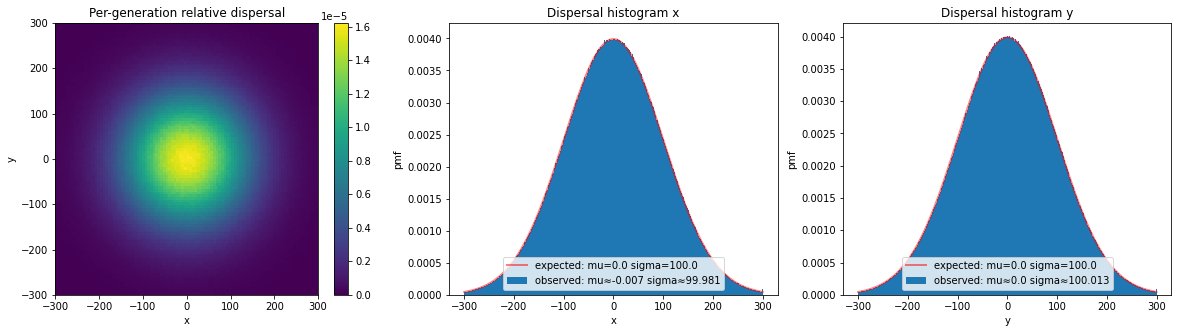

#### Parameters:
* seeds: [ 7819565580718957226 10448931625123074642  2065199937722172679
  1890255207686998468 16281815895904941660 12496989127914113312
 11169280878586495023   288348996827659059  6584868698408970884
 17238135665710984605]

#### Configuration:
```rust
(speciation:0.001,seed:17238135665710984605,sample:1.0,algorithm:Classical(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:orange'>*Gillespie*</span>

#### Fisher’s combined KS test:

* x-axis p-value: 0.2816311500203393
* x-axis statistic: 23.147065421911073

* y-axis p-value: 0.933185034506832
* y-axis statistic: 11.467554284438773

#### Dispersal Histograms:

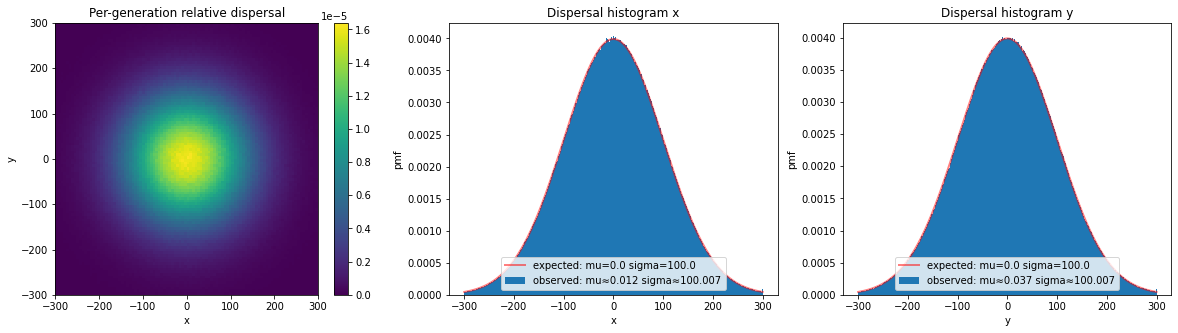

#### Parameters:
* seeds: [ 6005111787755335939 16628674583102505134 12367466779569556168
   490848819494183928 11082971822962177901  1075285887821790348
 14809609951519877174 11192895559178571650 13686032616924688542
  2693796522610826240]

#### Configuration:
```rust
(speciation:0.001,seed:2693796522610826240,sample:1.0,algorithm:Gillespie(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined KS test:

* x-axis p-value: 0.4040633800664457
* x-axis statistic: 20.88273622375756

* y-axis p-value: 0.4878832087389787
* y-axis statistic: 19.526407340629163

#### Dispersal Histograms:

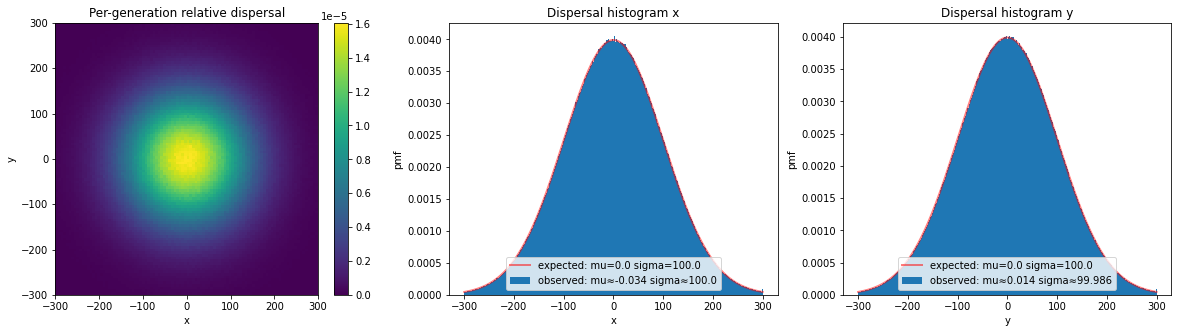

#### Parameters:
* seeds: [ 3861535631675471520 15943193507743748606  9910370643200532083
  1274841782314045611 17332632263872510165  9538271597240849494
   213663154102635985  9497475686355858648  1781288381009878971
 10495906443341479297]

#### Configuration:
```rust
(speciation:0.001,seed:10495906443341479297,sample:1.0,algorithm:SkippingGillespie(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:red'><u>Independent</u></span>

#### Fisher’s combined KS test:

* x-axis p-value: 0.9808210685151271
* x-axis statistic: 9.172557410136655

* y-axis p-value: 0.8567406896996426
* y-axis statistic: 13.460995372695647

#### Dispersal Histograms:

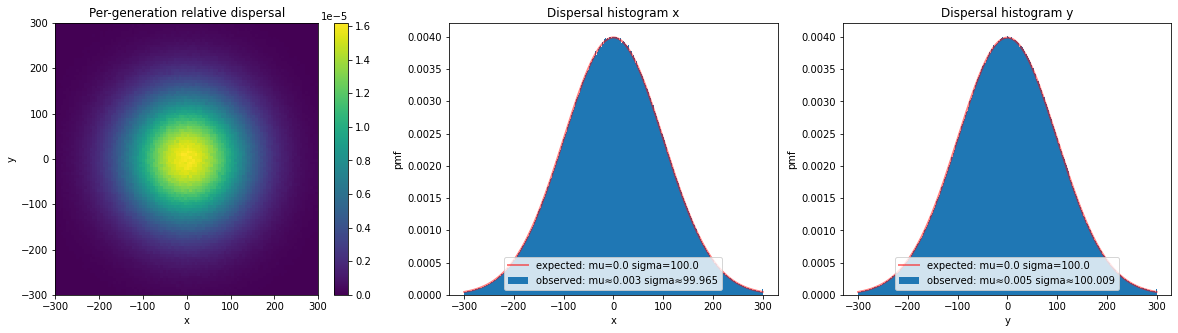

#### Parameters:
* seeds: [  286302319996191070 13896553656285283601  2142345007162328419
  1940957708699111076 14764936509870537459  3091232941699146593
   447766265054233474 15659990358388974148 15946074930292769221
 13981286937846532778]

#### Configuration:
```rust
(speciation:0.001,seed:13981286937846532778,sample:1.0,algorithm:Independent(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10)
    
    test_normal_dispersal_kernel(
        algorithm, speciation=0.001, seeds=seeds, sample=1.0, radius=25, sigma=100.0
    )